# CNN implementation with inception layers

An inception layer is a special layer which parametrize part of the network architecture. Instead of deciding which type of layer to use at every level, we equip the network with a set of "parallel" possible layers, letting it learn which to use. 

In this notebook we try to define and train network that exploits some inception layer, evaluating then the results on the test set.

## Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras as ks
from tensorflow.keras import layers
import pathlib

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

##Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

## Dataset splitting: train and validation

Constants:

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10
EPOCHS=15

The directories are moved and transformed in order to obtain the train and the test directories:

In [ ]:
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)

Found 3569 files belonging to 10 classes.
Using 3213 files for training.
Found 3569 files belonging to 10 classes.
Using 356 files for validation.
Found 402 files belonging to 10 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

# CNN with inception layers

## Model definition and training

In [ ]:
def inception_layer(previous_layer, filters):
	# 3x3 conv
	conv3 = Conv2D(filters, (3,3), padding='same', activation='relu')(previous_layer)
	# 5x5 conv
	conv5 = Conv2D(filters, (5,5), padding='same', activation='relu')(previous_layer)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(previous_layer)
	layer = concatenate([conv3, conv5, pool], axis=-1)
	return layer

class InceptionLayerCNN:

    def __init__(self, train=None, test=None, val=None, classes=11, name='InceptionLayerCNN'):
        # set datasets
        self.training_set = train
        self.val_set = val
        self.test_set = test
        self.name=name 
        
        # model
        inputs = ks.Input(shape=(224, 224, 3))
        x = layers.Rescaling(1. / 255)(inputs)
        x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
        x = inception_layer(x, 64)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = inception_layer(x, 128)
        x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64)(x)
        outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

        # utils
        self.history = None

        self.dir_name ="/content/drive/Shareddrives/CIDL/project/models/CNN"
        if not os.path.exists(self.dir_name):
          os.makedirs(self.dir_name)
        self.save_path = os.path.join(self.dir_name, name+'.h5')

        self.callbacks_list = [
                  ks.callbacks.ModelCheckpoint(
                      filepath=self.save_path,
                      monitor="val_loss",
                      verbose=1,
                      save_best_only=True) #saves the best model in terms of the metric in monitor
                  ]

    def compile_and_fit(self, optimizer='adam', loss='categorical_crossentropy', learning_rate=None):
        if learning_rate is not None:
            optimizer.learning_rate = learning_rate

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy']
        )

        self.history = self.model.fit(
             self.training_set,
             epochs=EPOCHS,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )   

    def plot_model(self, model_name):
        tf.keras.utils.plot_model(self.model, to_file=str(model_name) +".jpg", show_shapes=True)
    
    def train_more(self, epochs=EPOCHS):
      self.new_history = self.model.fit(
             self.training_set,
             epochs=epochs,
             validation_data=self.val_set,
             callbacks=self.callbacks_list
        )
      for key in self.history.history.keys():
        self.history.history[key].extend(self.new_history.history[key])
    
    def load_best_model(self):
      self.model = tf.keras.models.load_model(self.save_path)

    def save_history(self):
      with open(os.path.join(self.dir_name, self.name), 'wb') as file_pi:
        pickle.dump(self.history.history, file_pi)

    def load_history(self):
      with open(os.path.join(self.dir_name, self.name), 'rb') as file_pi:
        history = pickle.load(file_pi)
      return history

    def evaluate(self, test=None):
          if test == None:
            test = self.test_set
          test_loss, test_acc = self.model.evaluate(self.test_set)
          print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")

    def summary(self):
        self.model.summary()

In [ ]:
model_with_inception_layers = InceptionLayerCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
model_with_inception_layers.plot_model(model_name="inception_layers")
model_with_inception_layers.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d[0][0]']             

In [ ]:
model_with_inception_layers.compile_and_fit()

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 2.3385 - accuracy: 0.2428
Epoch 00001: val_loss improved from inf to 2.16893, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/InceptionLayerCNN.h5
26/26 [==============================] - 24s 654ms/step - loss: 2.3380 - accuracy: 0.2428 - val_loss: 2.1689 - val_accuracy: 0.2556
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.9568 - accuracy: 0.3059
Epoch 00002: val_loss improved from 2.16893 to 1.86707, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/InceptionLayerCNN.h5
26/26 [==============================] - 23s 645ms/step - loss: 1.9573 - accuracy: 0.3050 - val_loss: 1.8671 - val_accuracy: 0.3315
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.7200 - accuracy: 0.3806
Epoch 00003: val_loss improved from 1.86707 to 1.70683, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/InceptionLayerCNN.h5
26/26 [================

In [ ]:
model_with_inception_layers.train_more(epochs=15)

Epoch 1/15
25/26 [===========================>..] - ETA: 0s - loss: 0.7031 - accuracy: 0.7556
Epoch 00001: val_loss did not improve from 1.11569
26/26 [==============================] - 22s 610ms/step - loss: 0.7034 - accuracy: 0.7554 - val_loss: 1.1882 - val_accuracy: 0.6236
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 0.6485 - accuracy: 0.7663
Epoch 00002: val_loss did not improve from 1.11569
26/26 [==============================] - 22s 618ms/step - loss: 0.6464 - accuracy: 0.7672 - val_loss: 1.2207 - val_accuracy: 0.6404
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 0.5801 - accuracy: 0.8022
Epoch 00003: val_loss did not improve from 1.11569
26/26 [==============================] - 22s 623ms/step - loss: 0.5800 - accuracy: 0.8017 - val_loss: 1.1515 - val_accuracy: 0.6573
Epoch 4/15
25/26 [===========================>..] - ETA: 0s - loss: 0.5528 - accuracy: 0.8106
Epoch 00004: val_loss did not improve from 1.11569
26/26 [=================

In [ ]:
model_with_inception_layers.save_history()

## Visualize results

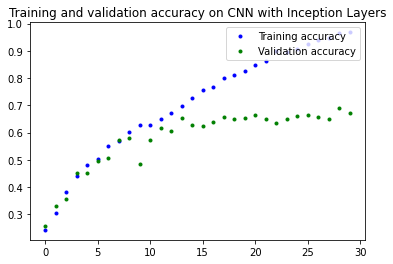

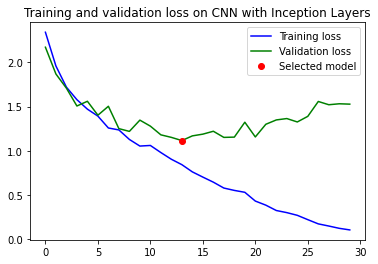

Lowest validation loss has been reached at epoch 13 with validation accuracy of 0.652


In [ ]:
history = InceptionLayerCNN().load_history()
name = 'CNN with Inception Layers'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
model_with_inception_layers.load_best_model()
model_with_inception_layers.evaluate(test_images)

4/4 [==============================] - 11s 102ms/step - loss: 0.8206 - accuracy: 0.6915
Test accuracy: 0.692, test loss: 0.821


# Larger FC

## Model definition and training

In [ ]:
def inception_layer(previous_layer, filters):
	# 3x3 conv
	conv3 = Conv2D(filters, (3,3), padding='same', activation='relu')(previous_layer)
	# 5x5 conv
	conv5 = Conv2D(filters, (5,5), padding='same', activation='relu')(previous_layer)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(previous_layer)
	layer = concatenate([conv3, conv5, pool], axis=-1)
	return layer

class LargerInceptionLayerCNN(InceptionLayerCNN):

    def __init__(self, train=None, test=None, val=None, classes=11, name='LargerInceptionLayerCNN'):
      super().__init__(train, test, val, classes, name)
        
      inputs = ks.Input(shape=(224, 224, 3))
      x = layers.Rescaling(1. / 255)(inputs)
      x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
      x = inception_layer(x, 64)
      x = layers.MaxPooling2D(pool_size=(2, 2))(x)
      x = inception_layer(x, 128)
      x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
      x = layers.Flatten()(x)
      x = layers.Dense(128)(x)
      x = layers.Dropout(0.2)(x)
      outputs = layers.Dense(classes, activation='softmax', name='predictions')(x)
      self.model = ks.Model(inputs=inputs, outputs=outputs)

      self.callbacks_list.append(ks.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

In [ ]:
larger_inception_layer = LargerInceptionLayerCNN(train=training_images, val=val_images, test=test_images, classes=NUM_CLASSES)
larger_inception_layer.plot_model(model_name="larger_inception_layers")
larger_inception_layer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 56, 56, 32)   896         ['rescaling_2[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 14, 14, 32)  0           ['conv2d_12[0][0]']        

In [ ]:
larger_inception_layer.compile_and_fit()

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 2.2637 - accuracy: 0.2160
Epoch 00001: val_loss improved from inf to 1.98073, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/LargerInceptionLayerCNN.h5
26/26 [==============================] - 25s 630ms/step - loss: 2.2637 - accuracy: 0.2160 - val_loss: 1.9807 - val_accuracy: 0.3315
Epoch 2/15
25/26 [===========================>..] - ETA: 0s - loss: 1.8605 - accuracy: 0.3541
Epoch 00002: val_loss improved from 1.98073 to 1.96111, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/LargerInceptionLayerCNN.h5
26/26 [==============================] - 22s 611ms/step - loss: 1.8589 - accuracy: 0.3548 - val_loss: 1.9611 - val_accuracy: 0.3624
Epoch 3/15
25/26 [===========================>..] - ETA: 0s - loss: 1.7102 - accuracy: 0.3859
Epoch 00003: val_loss improved from 1.96111 to 1.56531, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/LargerInceptionLayerCNN.h5
26/26

In [ ]:
larger_inception_layer.train_more(epochs=25)

Epoch 1/25
25/26 [===========================>..] - ETA: 0s - loss: 0.7845 - accuracy: 0.7225
Epoch 00001: val_loss did not improve from 1.11487
26/26 [==============================] - 22s 601ms/step - loss: 0.7843 - accuracy: 0.7230 - val_loss: 1.1676 - val_accuracy: 0.6067
Epoch 2/25
25/26 [===========================>..] - ETA: 0s - loss: 0.6955 - accuracy: 0.7556
Epoch 00002: val_loss improved from 1.11487 to 0.99612, saving model to /content/drive/Shareddrives/CIDL/project/models/CNN/LargerInceptionLayerCNN.h5
26/26 [==============================] - 22s 627ms/step - loss: 0.6940 - accuracy: 0.7563 - val_loss: 0.9961 - val_accuracy: 0.6770
Epoch 3/25
25/26 [===========================>..] - ETA: 0s - loss: 0.6382 - accuracy: 0.7775
Epoch 00003: val_loss did not improve from 0.99612
26/26 [==============================] - 22s 605ms/step - loss: 0.6379 - accuracy: 0.7775 - val_loss: 1.2513 - val_accuracy: 0.6489
Epoch 4/25
25/26 [===========================>..] - ETA: 0s - loss: 0

In [ ]:
larger_inception_layer.save_history()

## Visualize results

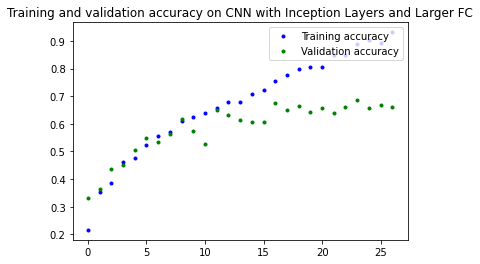

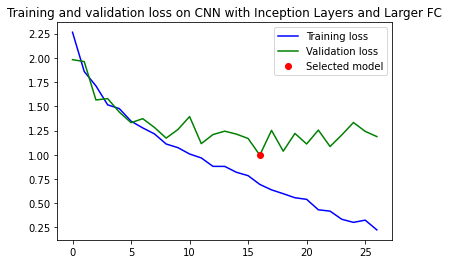

Lowest validation loss has been reached at epoch 16 with validation accuracy of 0.677


In [ ]:
history = LargerInceptionLayerCNN().load_history()
name = 'CNN with Inception Layers and Larger FC'

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
best_loss_epoch = np.argmin(val_loss)
best_loss = np.min(val_loss)
best_acc = val_acc[best_loss_epoch]

epochs = range(len(acc))

plt.plot(epochs, acc, 'b.', label='Training accuracy')
plt.plot(epochs, val_acc, 'g.', label='Validation accuracy')
plt.title('Training and validation accuracy on '+name)
plt.legend(loc='upper right')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
plt.title('Training and validation loss on '+name)
plt.legend(loc='upper right')

plt.show()
print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

## Evaluate against test set

Once trained our classifier, we pick the most performing one in the validation set and we test it against the test set

In [ ]:
larger_inception_layer.load_best_model()
larger_inception_layer.evaluate(test_images)

4/4 [==============================] - 3s 54ms/step - loss: 1.1133 - accuracy: 0.6219
Test accuracy: 0.622, test loss: 1.113
